In [1]:
from os import environ as ENV
DATA = ENV['PWD'] + '/data/'
FIGS = ENV['PWD'] + '/figures/'

In [2]:
import os
ENV['CUDA_VISIBLE_DEVICES'] = '1'

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid

import jax
import jax.numpy as jnp

import numpy as np
import numpy.typing as npt

Float = np.float64

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml

[cuda(id=0)]


In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [5]:
dev_gpu = qml.device("lightning.gpu", wires=18)  # GPU not that much slower, helps with indexing ig?
dev_cpu = qml.device("lightning.qubit", wires=4)  # CPU faster for 4 qubits
dev_cpu, dev_gpu

(<lightning.qubit device (wires=4) at 0x7f0340a3ddd0>,
 <lightning.gpu device (wires=18) at 0x7f03505552d0>)

In [6]:
circuit = {
    'ang': executor(dev_gpu)(circuit_angle_swap),
    'ang-qft': executor(dev_gpu)(circuit_angle_qft_swap), # exactly the same as ang
    'amp': executor(dev_cpu)(circuit_amp_iamp),
    'amp-qft': executor(dev_cpu)(circuit_amp_iamp_qft),
}

In [7]:
# test input for angle embedding
a = np.array(list(range(9)), dtype=Float)

# test input for amplitude embedding
b = np.array(list(range(16)), dtype=Float)

# Circuit figures

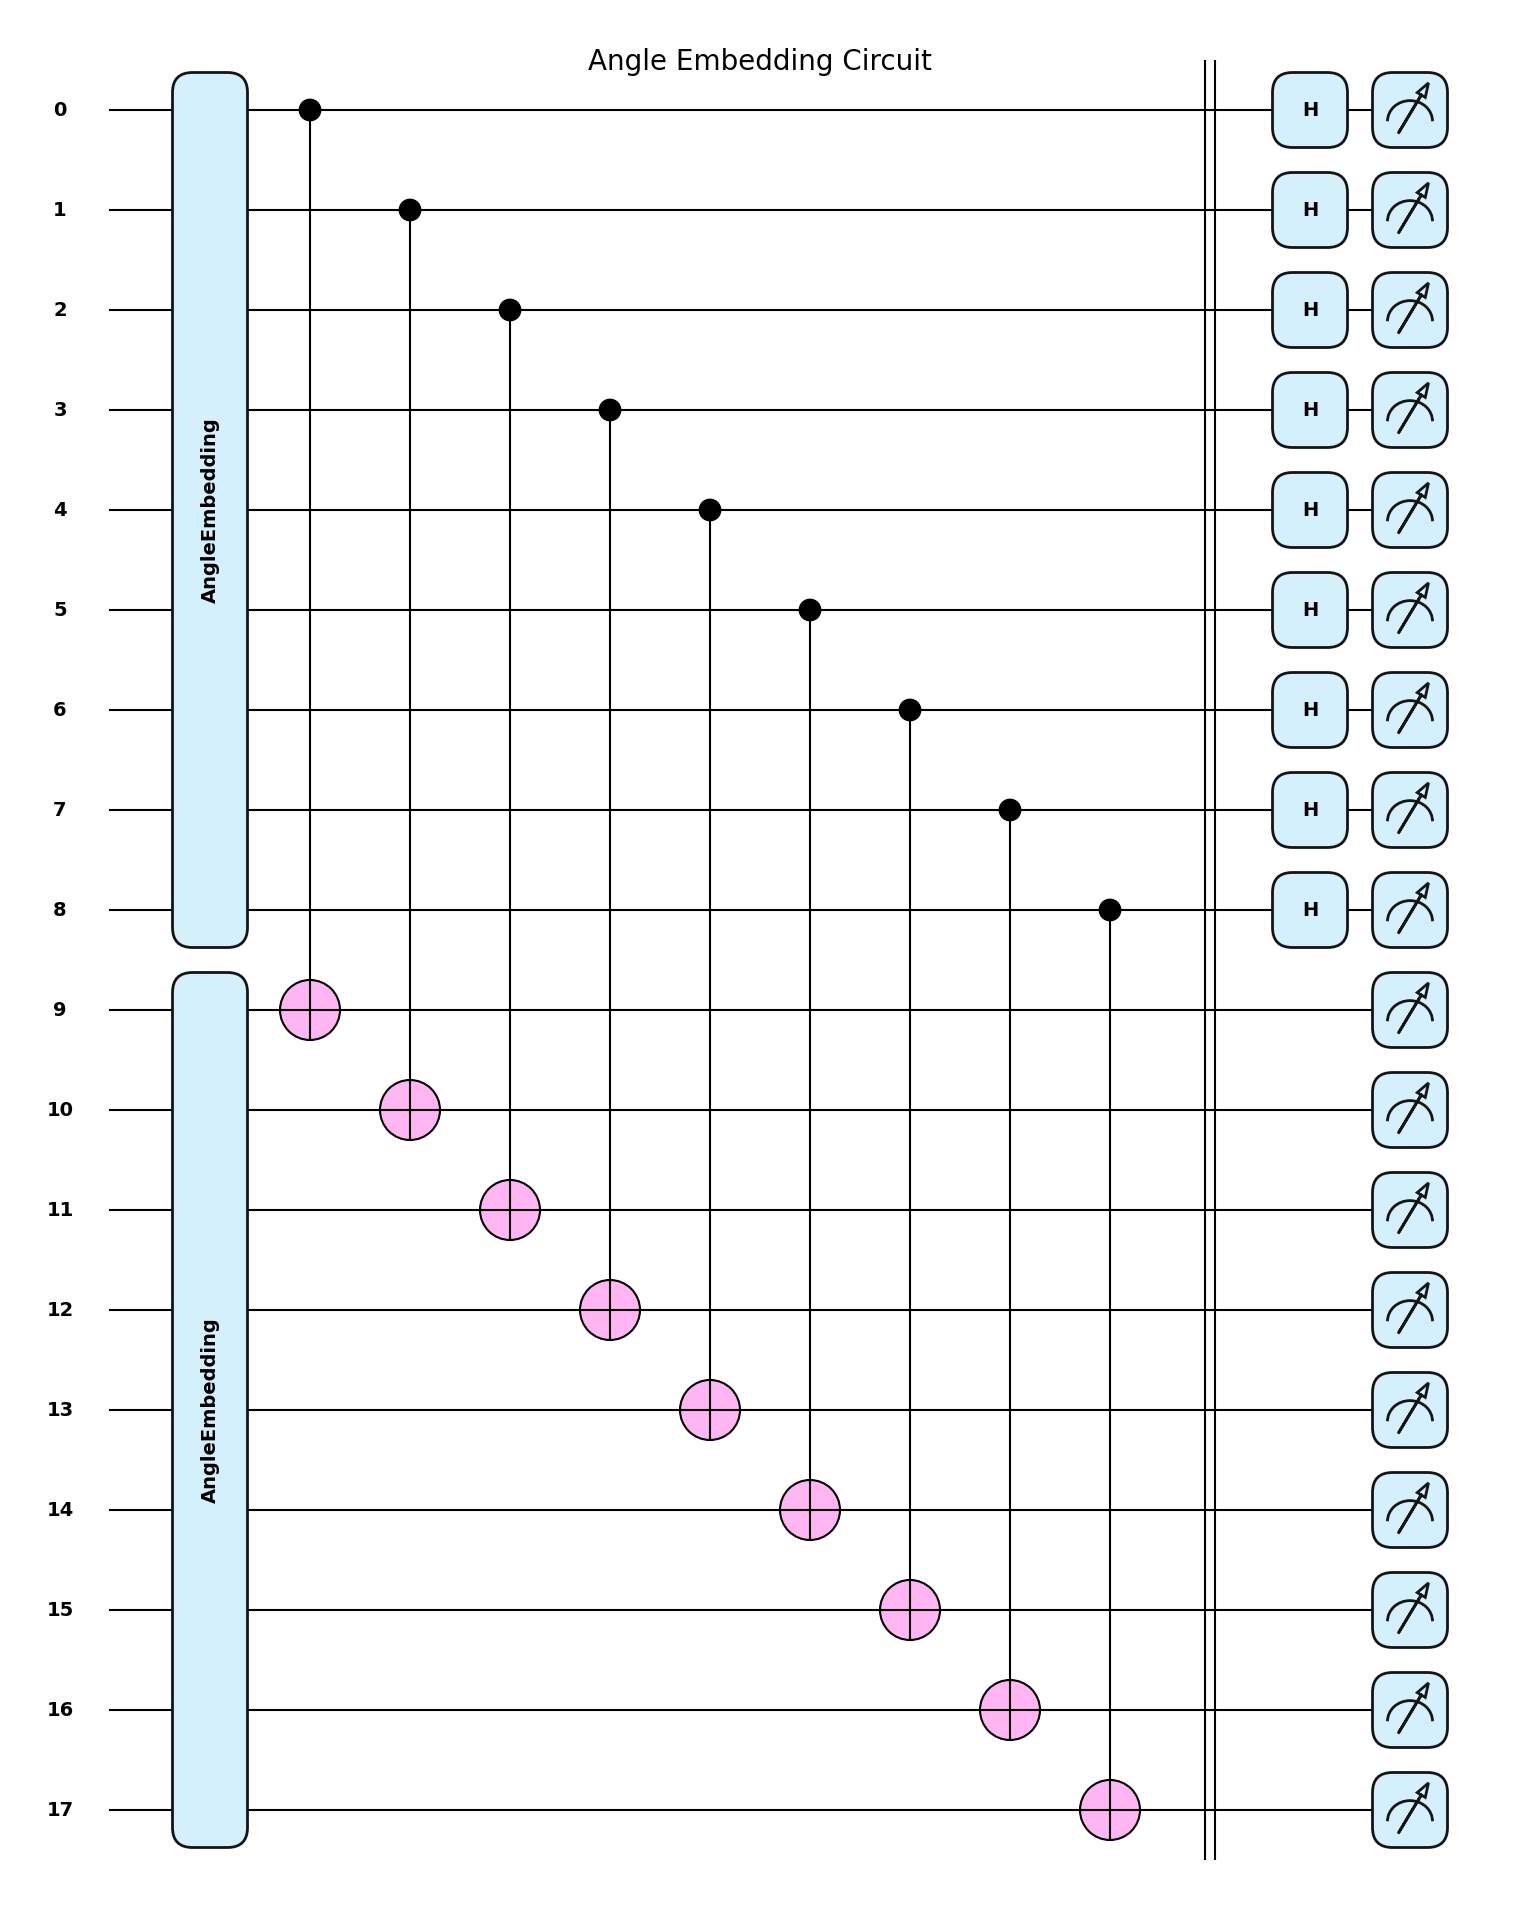

In [8]:
qml.draw_mpl(circuit['ang'], level='user', style='pennylane')(a, a)
plt.suptitle('Angle Embedding Circuit', fontsize=20)
plt.savefig(FIGS + 'pennylane-ang.png', dpi=300)
plt.show()

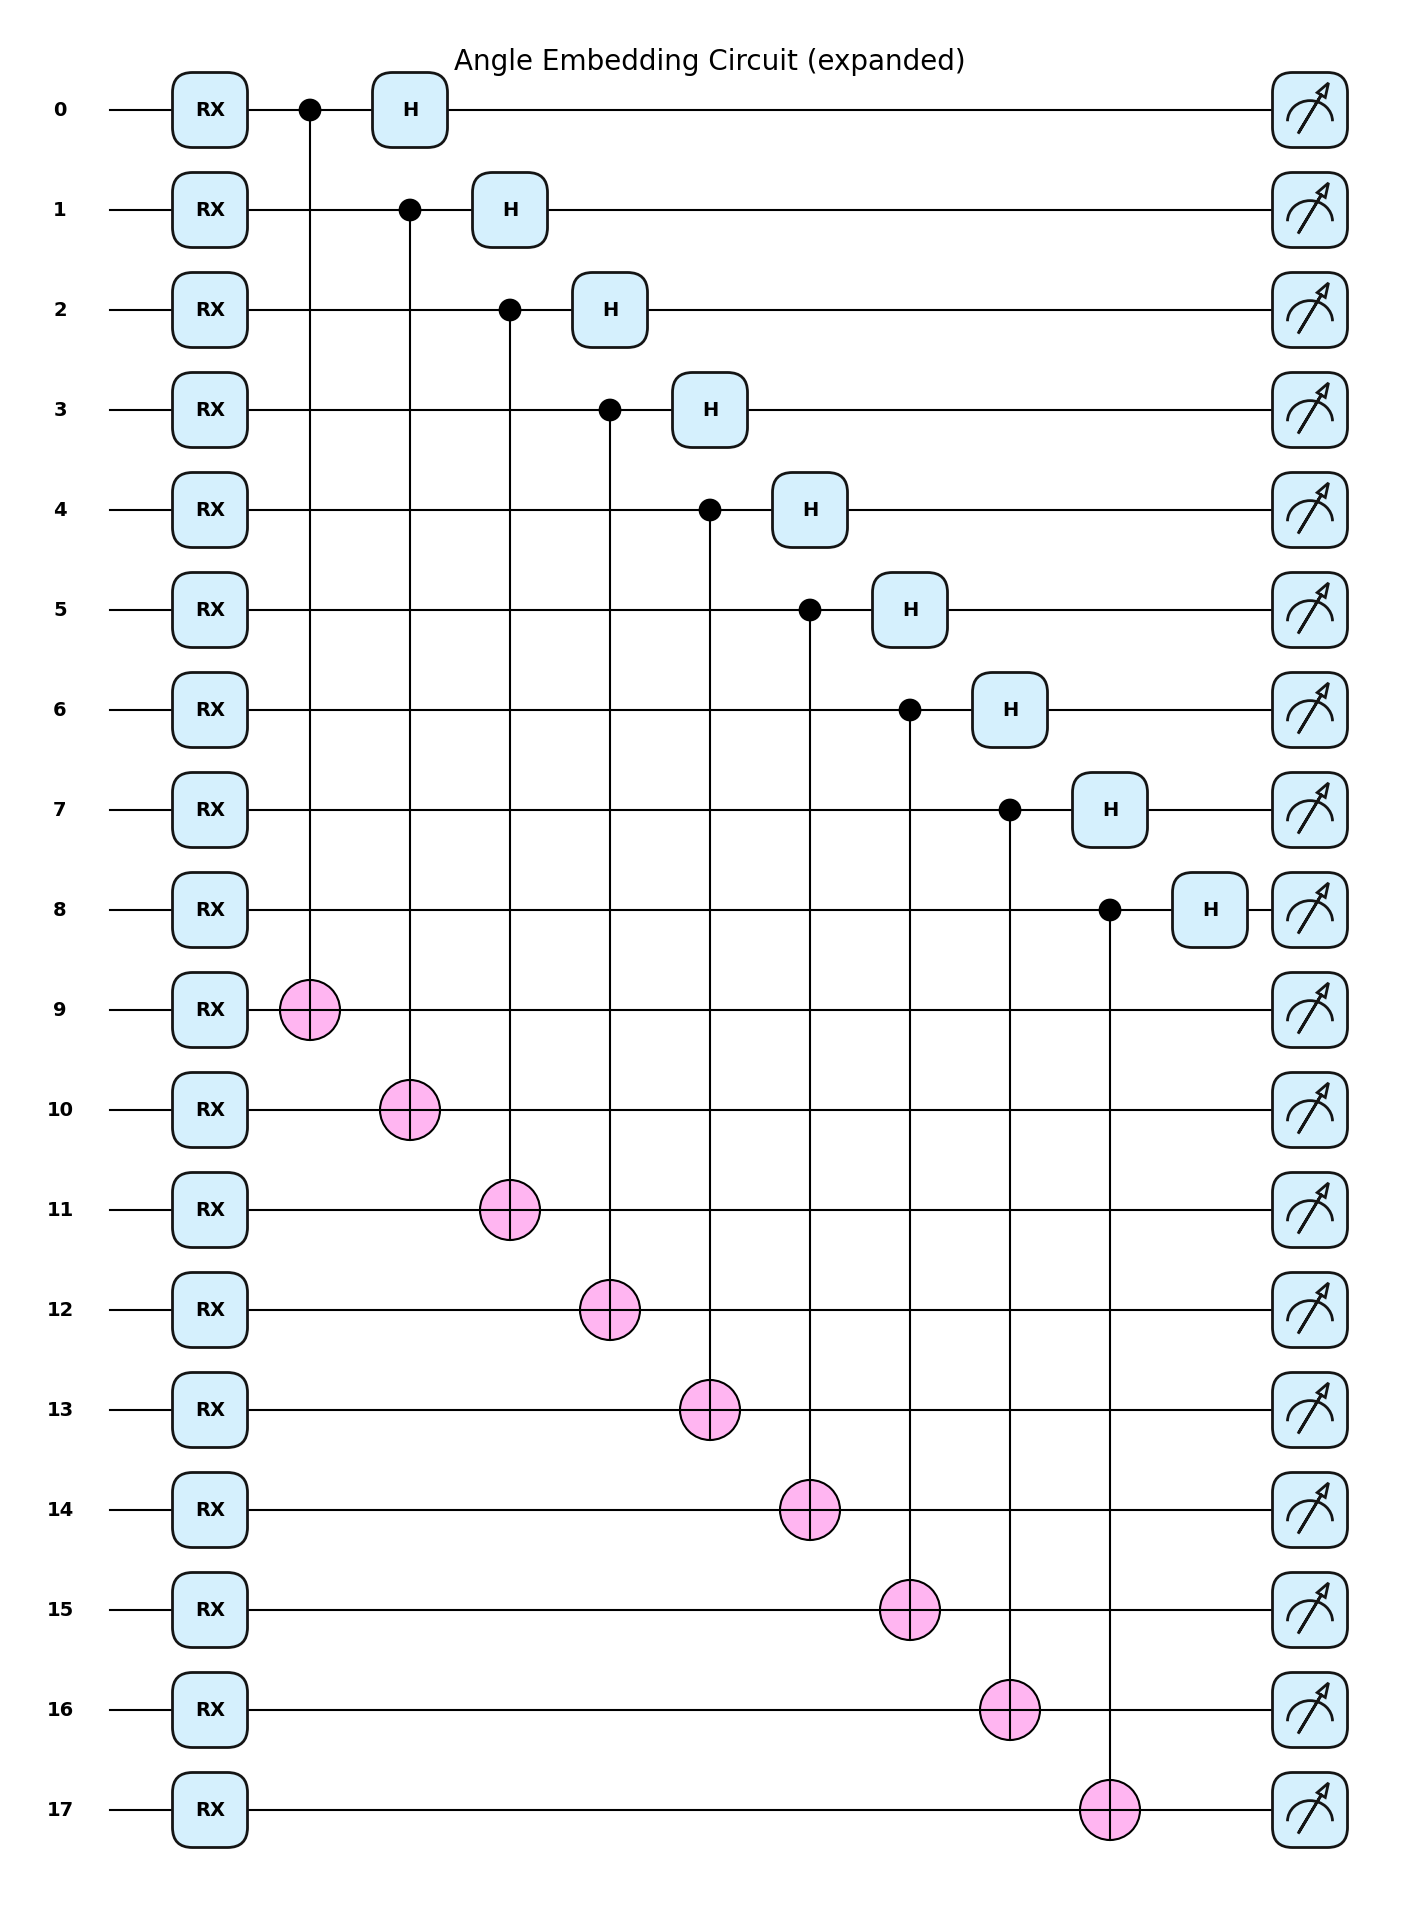

In [9]:
qml.draw_mpl(circuit['ang'], level='device', style='pennylane')(a, a)
plt.suptitle('Angle Embedding Circuit (expanded)', fontsize=20)
plt.savefig(FIGS + 'pennylane-ang-expanded.png', dpi=300)
plt.show()

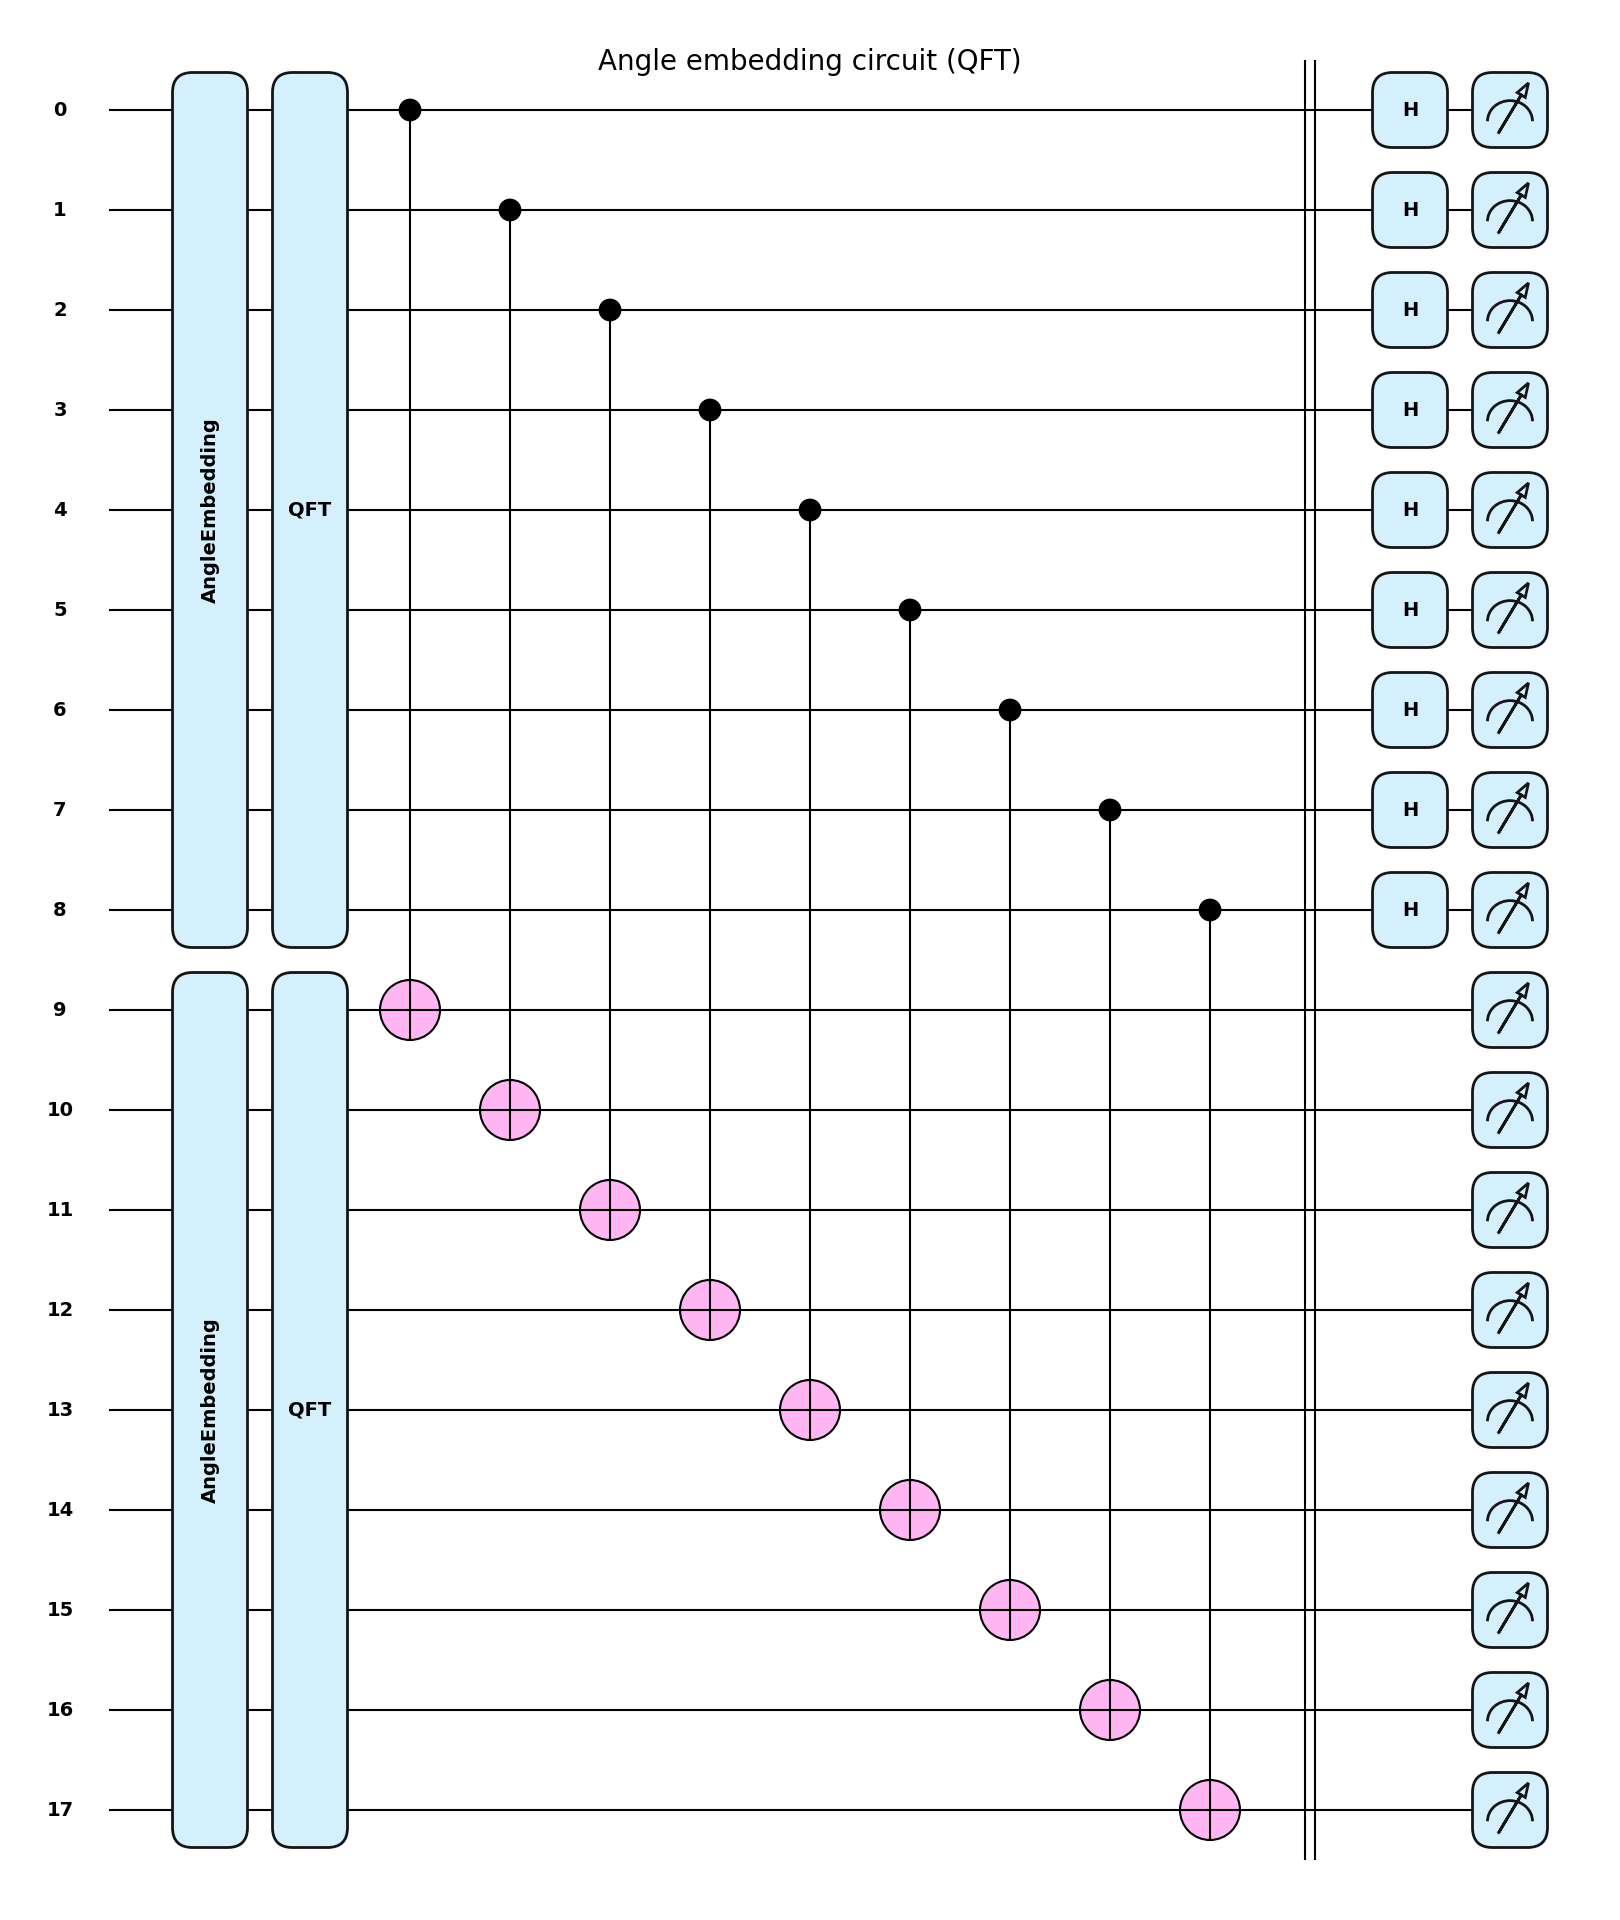

In [10]:
qml.draw_mpl(circuit['ang-qft'], level='user', style='pennylane')(a, a) # unused
plt.suptitle('Angle embedding circuit (QFT)', fontsize=20)
plt.show()

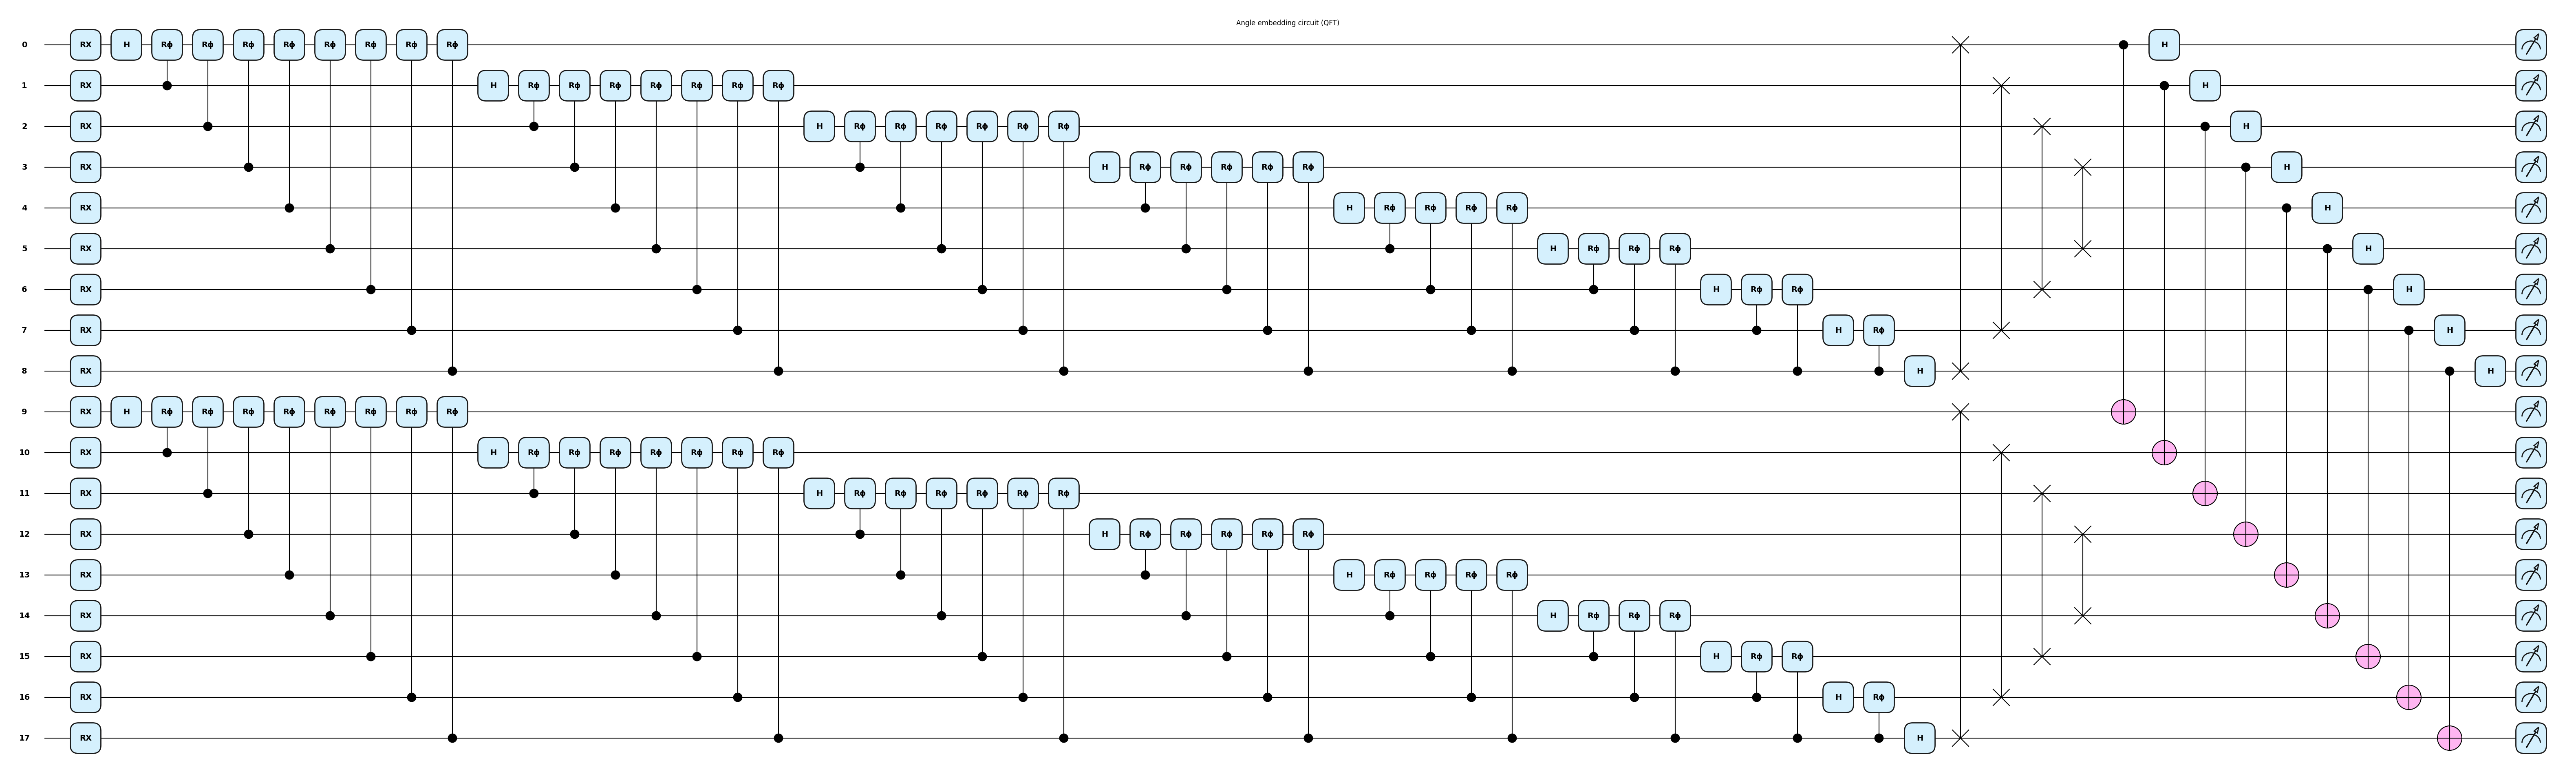

In [11]:
qml.draw_mpl(circuit['ang-qft'], level='device', style='pennylane')(a, a)
plt.suptitle('Angle embedding circuit (QFT)')
plt.show()

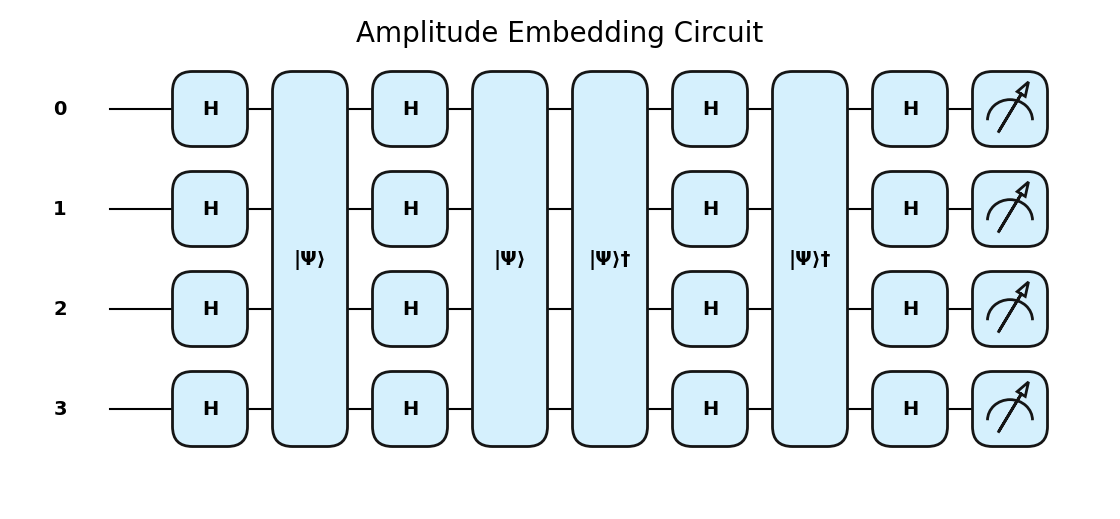

In [12]:
qml.draw_mpl(circuit['amp'], level='user', style='pennylane')(b, b)
plt.suptitle('Amplitude Embedding Circuit', fontsize=20)
plt.savefig(FIGS + 'pennylane-amp.png', dpi=300)
plt.show()

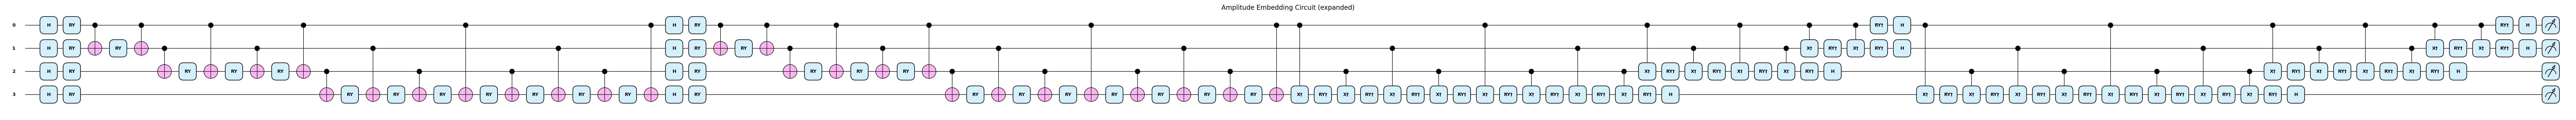

In [13]:
qml.draw_mpl(circuit['amp'], level='device', style='pennylane')(b, b)
plt.suptitle('Amplitude Embedding Circuit (expanded)', fontsize=20)
plt.savefig(FIGS + 'pennylane-amp-expanded.png', dpi=200)   # render to lower dpi bc it's very big when expanded
plt.show()

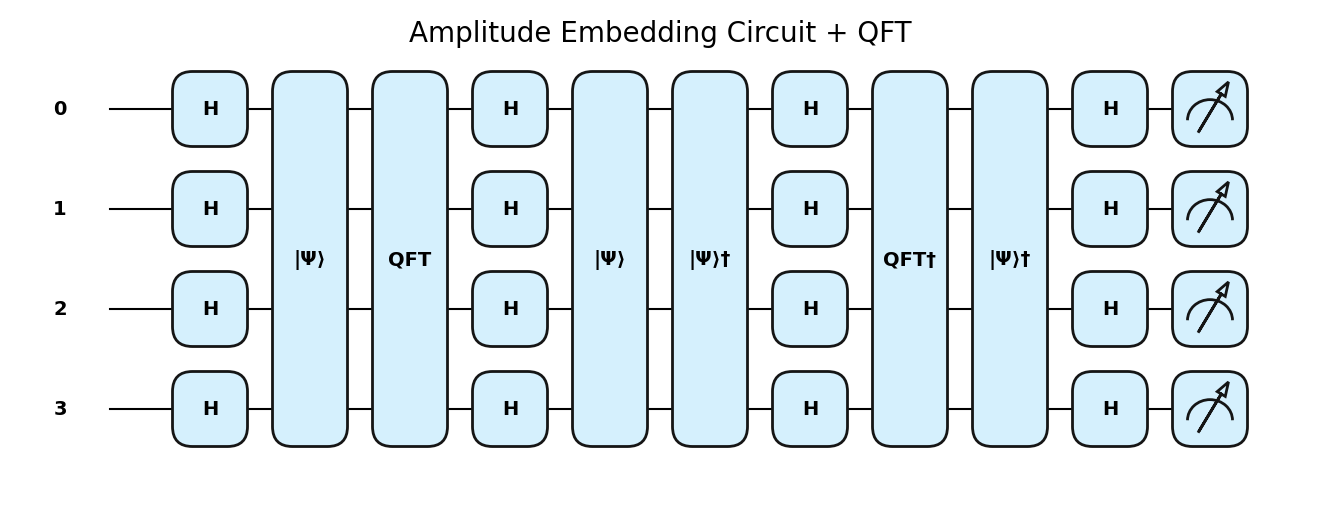

In [14]:
qml.draw_mpl(circuit['amp-qft'], level='user', style='pennylane')(b, b)
plt.suptitle('Amplitude Embedding Circuit + QFT', fontsize=20)
plt.savefig(FIGS + 'pennylane-amp-qft.png', dpi=300)
plt.show()

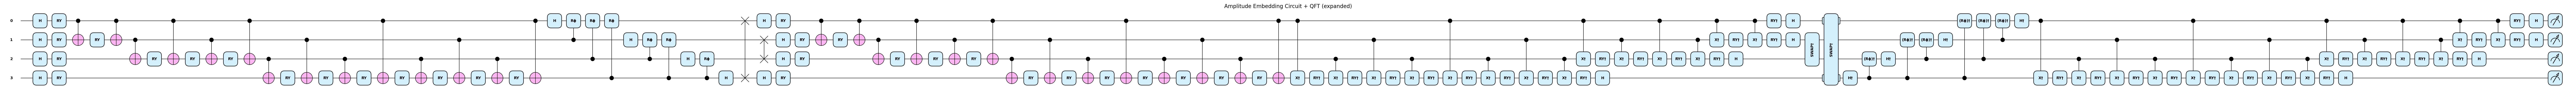

In [15]:
qml.draw_mpl(circuit['amp-qft'], level='device', style='pennylane')(b, b)
plt.suptitle('Amplitude Embedding Circuit + QFT (expanded)', fontsize=20)
plt.savefig(FIGS + 'pennylane-amp-qft-expanded.png', dpi=200)    # render to lower dpi bc it's very big when expanded
plt.show()

# Resource usage

In [16]:
qml.specs(circuit['ang'].original_function, level='device')(a, a)['resources']

num_wires: 18
num_gates: 36
depth: 3
shots: Shots(total=None)
gate_types:
{'RX': 18, 'CNOT': 9, 'Hadamard': 9}
gate_sizes:
{1: 27, 2: 9}


In [17]:
qml.specs(circuit['ang-qft'].original_function, level='device')(a, a)['resources']

num_wires: 18
num_gates: 134
depth: 21
shots: Shots(total=None)
gate_types:
{'RX': 18, 'Hadamard': 27, 'ControlledPhaseShift': 72, 'SWAP': 8, 'CNOT': 9}
gate_sizes:
{1: 45, 2: 89}


In [18]:
qml.specs(circuit['amp'].original_function, level='device')(b, b)['resources']

num_wires: 4
num_gates: 132
depth: 108
shots: Shots(total=None)
gate_types:
{'Hadamard': 16, 'RY': 30, 'CNOT': 28, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30}
gate_sizes:
{1: 76, 2: 56}


In [19]:
qml.specs(circuit['amp-qft'].original_function, level='device')(b, b)['resources']

num_wires: 4
num_gates: 156
depth: 124
shots: Shots(total=None)
gate_types:
{'Hadamard': 20, 'RY': 30, 'CNOT': 28, 'ControlledPhaseShift': 6, 'SWAP': 2, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30, 'Adjoint(SWAP)': 2, 'Adjoint(Hadamard)': 4, 'Adjoint(ControlledPhaseShift)': 6}
gate_sizes:
{1: 84, 2: 72}


# data loading

In [20]:
tuning_curves_rescaled = pd.read_csv(DATA + 'data_tuning-curves_rescaled.csv', index_col=0)
tuning_curves_rescaled

,3.0,4.2,6.0,8.5,12.0,17.0,24.0,33.9,48.0
23,0.086722,0.072027,0.168098,0.108906,0.152365,0.068859,0.123657,0.089995,0.129371
32,0.078608,0.080158,0.083181,0.095927,0.076528,0.215765,0.048417,0.207027,0.114388
35,0.104947,0.109836,0.126065,0.128293,0.150514,0.091618,0.096997,0.076197,0.115534
36,0.093583,0.082544,0.090014,0.114859,0.103090,0.105004,0.112459,0.106169,0.192279
37,0.076360,0.070309,0.142336,0.141239,0.119215,0.103641,0.104605,0.129937,0.112358
...,...,...,...,...,...,...,...,...,...
424,0.067342,0.045351,0.250037,0.122910,0.115004,0.108915,0.058867,0.053632,0.177941
425,0.097614,0.075945,0.135653,0.127716,0.161124,0.093613,0.095308,0.094377,0.118650
426,0.099993,0.092348,0.164751,0.119127,0.081755,0.108576,0.106285,0.111183,0.115983
428,0.097932,0.089850,0.120197,0.121800,0.138243,0.095211,0.135635,0.111317,0.089815


In [21]:
tuning_curves_resampled = pd.read_csv(DATA + 'data_tuning-curves_resampled.csv', index_col=0)
tuning_curves_resampled

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,0.249401,0.202876,0.215822,0.381545,0.477977,0.363946,0.328327,0.420292,0.395173,0.226299,0.234197,0.348727,0.321776,0.260525,0.283331,0.372055
32,0.210521,0.212389,0.215030,0.218653,0.225051,0.243891,0.256888,0.218355,0.255731,0.525098,0.485378,0.153590,0.255523,0.539996,0.533203,0.306344
35,0.309418,0.314312,0.325680,0.351903,0.374615,0.375823,0.387094,0.431047,0.420952,0.295464,0.272117,0.287846,0.263679,0.227092,0.247214,0.340632
36,0.270817,0.249543,0.239007,0.246740,0.267567,0.313758,0.330254,0.305926,0.298756,0.301466,0.309979,0.322530,0.323486,0.307544,0.369911,0.556431
37,0.223829,0.196587,0.213158,0.337854,0.420684,0.424024,0.403091,0.366207,0.335284,0.309221,0.299846,0.302911,0.331483,0.377468,0.378078,0.329346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.175457,0.100653,0.135142,0.458584,0.638404,0.425371,0.315741,0.304242,0.296386,0.289515,0.254567,0.169513,0.127769,0.135220,0.233321,0.463616
425,0.285618,0.232911,0.227782,0.330195,0.398631,0.378123,0.388203,0.454541,0.442974,0.299799,0.275088,0.278689,0.277691,0.276072,0.294305,0.347169
426,0.294296,0.264661,0.278617,0.409499,0.478998,0.403743,0.326582,0.254932,0.253694,0.309808,0.317388,0.312215,0.318011,0.326297,0.333937,0.341359
428,0.290078,0.268255,0.269075,0.320892,0.358403,0.358273,0.368374,0.399865,0.393229,0.299162,0.309085,0.396847,0.379553,0.334062,0.298943,0.266034


In [22]:
def get_fidelity(data1:list[int], data2:list[int], circuit, postprocess) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1, circuit, postprocess)

    probs = circuit(data1, data2)
    fidelity = postprocess(probs)
    return fidelity

def get_fidelities(datum, circuit, postprocess):
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'fidelity'])

    # A x B
    pairs, pairs_len = combinations(datum.index, 2), (len(datum) * (len(datum) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = datum.loc[a], datum.loc[b]
        fidelity = get_fidelity(a_i, b_i, circuit, postprocess)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, fidelity]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, fidelity]

    # A x A (should all be 1)
    for a in tqdm(datum.index):
        a_i = datum.loc[a]
        fidelity = get_fidelity(a_i, a_i, circuit, postprocess)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, fidelity]

    quantum_fidelity = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['fidelity'].astype(np.float64)
    return quantum_fidelity


In [23]:
results = {}

In [25]:
# fidelity defined as average of eigenvalues??
results['ang'] = get_fidelities(
    tuning_curves_rescaled,
    circuit['ang'],
    lambda probs: swap_expectation(probs, len(tuning_curves_rescaled.columns))[1]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [27]:
# fidelity defined as average of eigenvalues??
results['ang-qft'] = get_fidelities(
    tuning_curves_rescaled,
    circuit['ang-qft'],
    lambda probs: swap_expectation(probs, len(tuning_curves_rescaled.columns))[1]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [24]:
# fidelity defined as prob of 0 state
results['amp'] = get_fidelities(
    tuning_curves_resampled,
    circuit['amp'],
    lambda probs: probs[0]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [26]:
results['amp-qft'] = get_fidelities(
    tuning_curves_resampled,
    circuit['amp-qft'],
    lambda probs: probs[0]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [28]:
# Save the results for analysis
for k, v in results.items():
    v.to_csv(DATA + f'results_simulator_{k}.csv')